In [49]:
import warnings
warnings.filterwarnings('ignore')

import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import pandas_ta as ta
import seaborn as sns

In [50]:
dolar_df = pd.read_csv('./data-projects/dolar_D_2307.csv')
dolar_df.set_index('Data', inplace=True)
dolar_df = dolar_df[::-1]
dolar_df

,Abertura,Máxima,Mínima,Fechamento,BOP,VOL,Compradores,Vendedores,Saldo
Data,,,,,,,,,
2014-03-05,3667.4988,3669.0542,3627.0599,3630.9483,-0.8704,3.097117e+10,0,0,0
2014-03-06,3620.8385,3639.5026,3604.5074,3638.7250,0.5111,5.893776e+10,0,0,0
2014-03-07,3635.6143,3678.3862,3633.2813,3664.3881,0.6379,5.799550e+10,0,0,0
2014-03-10,3664.3881,3687.7183,3641.8357,3678.3862,0.3051,5.786549e+10,0,0,0
2014-03-11,3685.3853,3705.6047,3659.7221,3698.6057,0.2881,6.058720e+10,0,0,0
...,...,...,...,...,...,...,...,...,...
2021-07-19,5168.5000,5265.5000,5159.5000,5259.0000,0.8538,7.681582e+10,128115,-123845,4270
2021-07-20,5250.0000,5301.0000,5208.5000,5228.0000,-0.2378,7.046589e+10,110000,-117505,-7505
2021-07-21,5238.0000,5283.5000,5187.0000,5194.5000,-0.4508,8.043548e+10,119365,-129670,-10305


In [51]:
# médias
dolar_df['M20'] = ta.sma(dolar_df['Fechamento'], length=20)
dolar_df['M50'] = ta.sma(dolar_df['Fechamento'], length=50)
dolar_df['M200'] = ta.sma(dolar_df['Fechamento'], length=200)

# distancia média
dolar_df['Dist20'] = dolar_df['Fechamento'] - dolar_df['M20'] 
dolar_df['Dist50'] = dolar_df['Fechamento'] - dolar_df['M50']
dolar_df['Dist200'] = dolar_df['Fechamento'] - dolar_df['M200']

# variação
dolar_df['Variação'] = dolar_df['Fechamento'].pct_change()

# classes 0(venda)/1(compra)
dolar_df['Classe'] = dolar_df['Variação'].apply([lambda x:1 if x >0 else 0])

# correr a classe 1 dia para poder gerar previsão
dolar_df['Classe'] = dolar_df['Classe'].shift(-1)
dolar_df.tail()


,Abertura,Máxima,Mínima,Fechamento,BOP,VOL,Compradores,Vendedores,Saldo,M20,M50,M200,Dist20,Dist50,Dist200,Variação,Classe
Data,,,,,,,,,,,,,,,,,
2021-07-19,5168.5,5265.5,5159.5,5259.0,0.8538,7.681582e+10,128115,-123845,4270,5084.148295,5162.582126,5432.771166,174.851705,96.417874,-173.771166,0.027048,0.0
2021-07-20,5250.0,5301.0,5208.5,5228.0,-0.2378,7.046589e+10,110000,-117505,-7505,5093.939355,5161.613246,5430.982256,134.060645,66.386754,-202.982256,-0.005895,0.0
2021-07-21,5238.0,5283.5,5187.0,5194.5,-0.4508,8.043548e+10,119365,-129670,-10305,5104.888680,5160.275964,5428.754666,89.611320,34.224036,-234.254666,-0.006408,1.0
2021-07-22,5186.5,5229.5,5173.5,5205.5,0.3393,4.981865e+10,86065,-84660,1405,5115.911615,5159.259214,5426.085337,89.588385,46.240786,-220.585337,0.002118,0.0
2021-07-23,5203.5,5236.5,5163.0,5203.5,0.0000,5.767838e+10,95580,-97285,-1705,5129.517375,5156.503466,5423.532727,73.982625,46.996534,-220.032727,-0.000384,NaN


In [52]:
dolar_df = dolar_df.dropna()

In [53]:
dolar_df.nunique()

Abertura       1575
Máxima         1578
Mínima         1579
Fechamento     1583
BOP            1450
VOL            1627
Compradores     992
Vendedores     1003
Saldo           921
M20            1627
M50            1627
M200           1627
Dist20         1627
Dist50         1627
Dist200        1627
Variação       1620
Classe            2
dtype: int64

In [54]:
# filtro dos valores para os diferentes de 0
dolar_df = dolar_df.loc[dolar_df['Compradores'] != 0]
dolar_df

,Abertura,Máxima,Mínima,Fechamento,BOP,VOL,Compradores,Vendedores,Saldo,M20,M50,M200,Dist20,Dist50,Dist200,Variação,Classe
Data,,,,,,,,,,,,,,,,,
2017-06-06,3734.8525,3736.5399,3703.3537,3708.9785,-0.7797,4.456790e+10,97950,-105830,-7880,3662.143360,3624.420792,3782.264422,46.835140,84.557708,-73.285922,-0.006329,0.0
2017-06-07,3712.3534,3717.4157,3693.2291,3697.7289,-0.6047,4.147236e+10,99765,-94740,5025,3666.782370,3626.846058,3781.133080,30.946530,70.882842,-83.404180,-0.003033,0.0
2017-06-08,3705.6036,3719.1031,3687.6043,3687.6043,-0.5714,4.030693e+10,86135,-96180,-10045,3672.499995,3628.655368,3779.929759,15.104305,58.948932,-92.325459,-0.002738,1.0
2017-06-09,3688.1668,3727.5403,3680.8546,3724.1654,0.7711,4.743102e+10,109490,-107195,2295,3681.177705,3630.931742,3778.704837,42.987695,93.233658,-54.539437,0.009915,1.0
2017-06-12,3716.2907,3759.6015,3702.7912,3747.7895,0.5545,5.142668e+10,119305,-121080,-1775,3691.687535,3634.151488,3777.805493,56.101965,113.638012,-30.015993,0.006343,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-16,5113.5000,5135.0000,5081.0000,5120.5000,0.1296,5.687428e+10,98750,-97705,1045,5076.743720,5163.845852,5434.818182,43.756280,-43.345852,-314.318182,-0.000488,1.0
2021-07-19,5168.5000,5265.5000,5159.5000,5259.0000,0.8538,7.681582e+10,128115,-123845,4270,5084.148295,5162.582126,5432.771166,174.851705,96.417874,-173.771166,0.027048,0.0
2021-07-20,5250.0000,5301.0000,5208.5000,5228.0000,-0.2378,7.046589e+10,110000,-117505,-7505,5093.939355,5161.613246,5430.982256,134.060645,66.386754,-202.982256,-0.005895,0.0


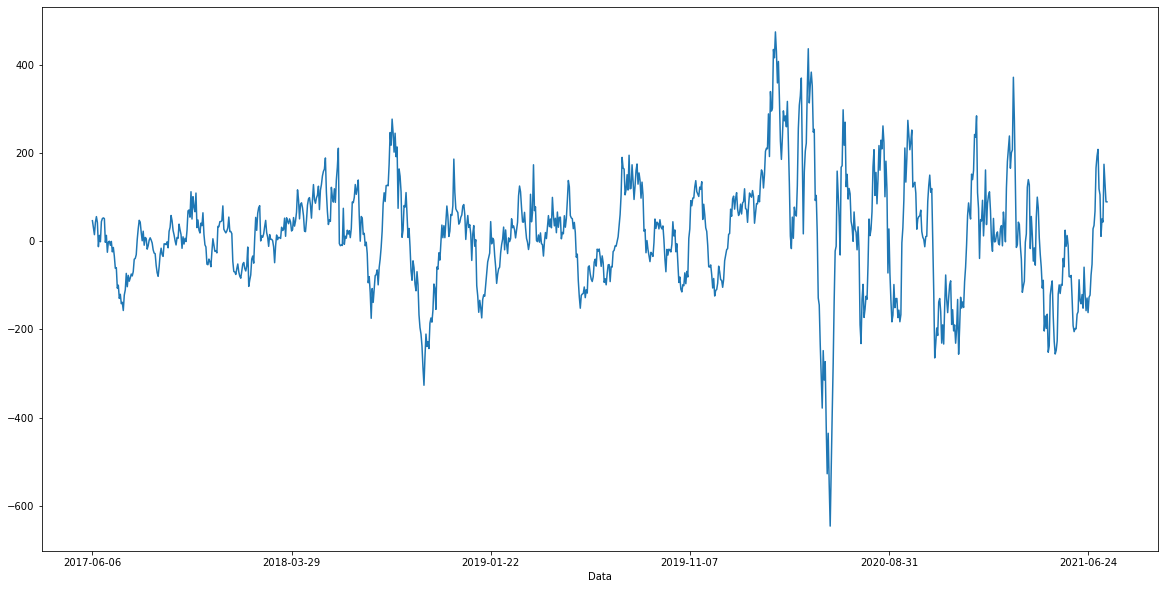

In [55]:
plt.figure(figsize=(20,10))
dolar_df['Dist20'].plot();

In [56]:
correlação = dolar_df.corr()

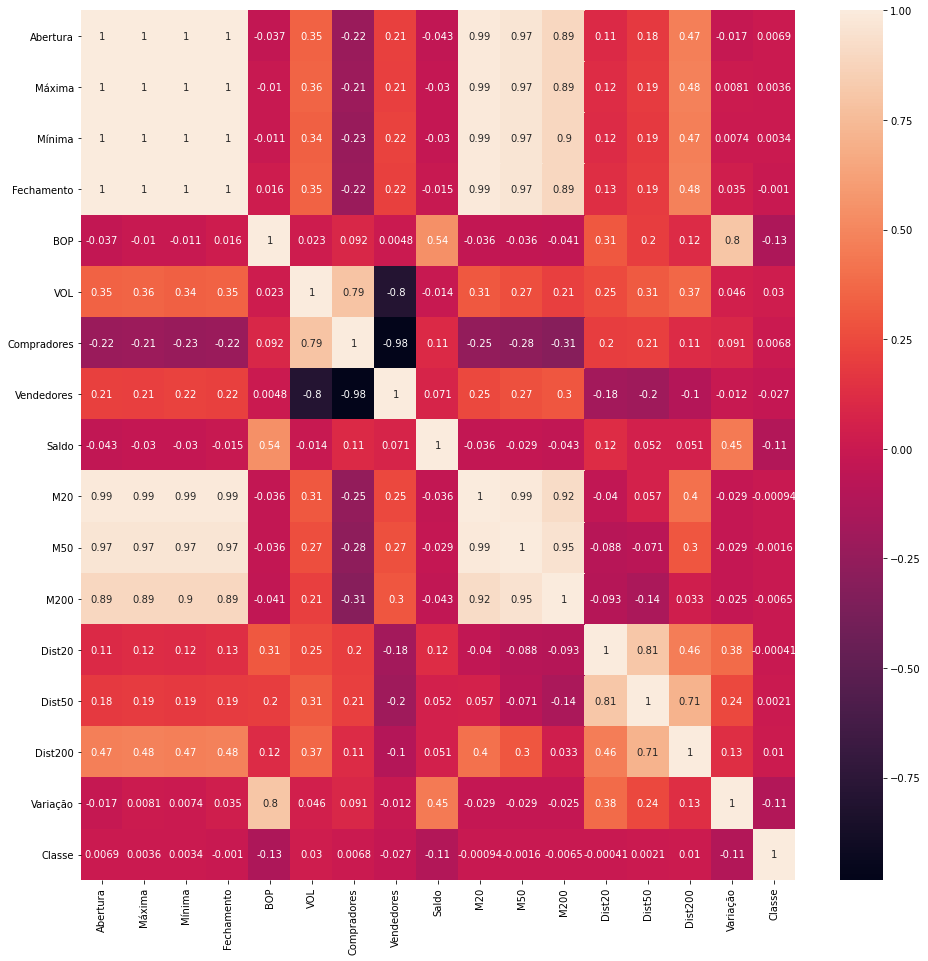

In [57]:
plt.figure(figsize=(16,16))
sns.heatmap(correlação, annot=True);

In [58]:
dolar_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1020 entries, 2017-06-06 to 2021-07-22
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Abertura     1020 non-null   float64
 1   Máxima       1020 non-null   float64
 2   Mínima       1020 non-null   float64
 3   Fechamento   1020 non-null   float64
 4   BOP          1020 non-null   float64
 5   VOL          1020 non-null   float64
 6   Compradores  1020 non-null   int64  
 7   Vendedores   1020 non-null   int64  
 8   Saldo        1020 non-null   int64  
 9   M20          1020 non-null   float64
 10  M50          1020 non-null   float64
 11  M200         1020 non-null   float64
 12  Dist20       1020 non-null   float64
 13  Dist50       1020 non-null   float64
 14  Dist200      1020 non-null   float64
 15  Variação     1020 non-null   float64
 16  Classe       1020 non-null   float64
dtypes: float64(14), int64(3)
memory usage: 143.4+ KB


In [59]:
# dataframe com atributos numericos
df_teste = dolar_df[['Variação','Dist200','Dist50','Dist20','M200','M50','M20','Saldo','Vendedores','Compradores','VOL','BOP','Fechamento','Mínima','Máxima','Abertura']]
df_teste

,Variação,Dist200,Dist50,Dist20,M200,M50,M20,Saldo,Vendedores,Compradores,VOL,BOP,Fechamento,Mínima,Máxima,Abertura
Data,,,,,,,,,,,,,,,,
2017-06-06,-0.006329,-73.285922,84.557708,46.835140,3782.264422,3624.420792,3662.143360,-7880,-105830,97950,4.456790e+10,-0.7797,3708.9785,3703.3537,3736.5399,3734.8525
2017-06-07,-0.003033,-83.404180,70.882842,30.946530,3781.133080,3626.846058,3666.782370,5025,-94740,99765,4.147236e+10,-0.6047,3697.7289,3693.2291,3717.4157,3712.3534
2017-06-08,-0.002738,-92.325459,58.948932,15.104305,3779.929759,3628.655368,3672.499995,-10045,-96180,86135,4.030693e+10,-0.5714,3687.6043,3687.6043,3719.1031,3705.6036
2017-06-09,0.009915,-54.539437,93.233658,42.987695,3778.704837,3630.931742,3681.177705,2295,-107195,109490,4.743102e+10,0.7711,3724.1654,3680.8546,3727.5403,3688.1668
2017-06-12,0.006343,-30.015993,113.638012,56.101965,3777.805493,3634.151488,3691.687535,-1775,-121080,119305,5.142668e+10,0.5545,3747.7895,3702.7912,3759.6015,3716.2907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-16,-0.000488,-314.318182,-43.345852,43.756280,5434.818182,5163.845852,5076.743720,1045,-97705,98750,5.687428e+10,0.1296,5120.5000,5081.0000,5135.0000,5113.5000
2021-07-19,0.027048,-173.771166,96.417874,174.851705,5432.771166,5162.582126,5084.148295,4270,-123845,128115,7.681582e+10,0.8538,5259.0000,5159.5000,5265.5000,5168.5000
2021-07-20,-0.005895,-202.982256,66.386754,134.060645,5430.982256,5161.613246,5093.939355,-7505,-117505,110000,7.046589e+10,-0.2378,5228.0000,5208.5000,5301.0000,5250.0000


In [60]:
dolar_df

,Abertura,Máxima,Mínima,Fechamento,BOP,VOL,Compradores,Vendedores,Saldo,M20,M50,M200,Dist20,Dist50,Dist200,Variação,Classe
Data,,,,,,,,,,,,,,,,,
2017-06-06,3734.8525,3736.5399,3703.3537,3708.9785,-0.7797,4.456790e+10,97950,-105830,-7880,3662.143360,3624.420792,3782.264422,46.835140,84.557708,-73.285922,-0.006329,0.0
2017-06-07,3712.3534,3717.4157,3693.2291,3697.7289,-0.6047,4.147236e+10,99765,-94740,5025,3666.782370,3626.846058,3781.133080,30.946530,70.882842,-83.404180,-0.003033,0.0
2017-06-08,3705.6036,3719.1031,3687.6043,3687.6043,-0.5714,4.030693e+10,86135,-96180,-10045,3672.499995,3628.655368,3779.929759,15.104305,58.948932,-92.325459,-0.002738,1.0
2017-06-09,3688.1668,3727.5403,3680.8546,3724.1654,0.7711,4.743102e+10,109490,-107195,2295,3681.177705,3630.931742,3778.704837,42.987695,93.233658,-54.539437,0.009915,1.0
2017-06-12,3716.2907,3759.6015,3702.7912,3747.7895,0.5545,5.142668e+10,119305,-121080,-1775,3691.687535,3634.151488,3777.805493,56.101965,113.638012,-30.015993,0.006343,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-16,5113.5000,5135.0000,5081.0000,5120.5000,0.1296,5.687428e+10,98750,-97705,1045,5076.743720,5163.845852,5434.818182,43.756280,-43.345852,-314.318182,-0.000488,1.0
2021-07-19,5168.5000,5265.5000,5159.5000,5259.0000,0.8538,7.681582e+10,128115,-123845,4270,5084.148295,5162.582126,5432.771166,174.851705,96.417874,-173.771166,0.027048,0.0
2021-07-20,5250.0000,5301.0000,5208.5000,5228.0000,-0.2378,7.046589e+10,110000,-117505,-7505,5093.939355,5161.613246,5430.982256,134.060645,66.386754,-202.982256,-0.005895,0.0


In [61]:
# normalização dos valores para os atributos com valores maiores para não ter pesos diferentes no algoritmo
scaler = MinMaxScaler()
X = scaler.fit_transform(df_teste)

In [62]:
X

array([[0.49429324, 0.22439209, 0.51066693, ..., 0.11751393, 0.11033518,
        0.12040697],
       [0.53195262, 0.21938105, 0.50055924, ..., 0.1134774 , 0.10305252,
        0.11175615],
       [0.53532333, 0.21496282, 0.49173836, ..., 0.11123488, 0.1036951 ,
        0.10916088],
       ...,
       [0.49925728, 0.16016038, 0.49723598, ..., 0.71759281, 0.7060944 ,
        0.70297496],
       [0.49339426, 0.14467282, 0.47346311, ..., 0.70902109, 0.69943026,
        0.69836101],
       [0.59080246, 0.15144251, 0.48234521, ..., 0.70363884, 0.67886662,
        0.67855947]])

In [63]:
y = dolar_df['Classe']
y

Data
2017-06-06    0.0
2017-06-07    0.0
2017-06-08    1.0
2017-06-09    1.0
2017-06-12    0.0
             ... 
2021-07-16    1.0
2021-07-19    0.0
2021-07-20    0.0
2021-07-21    1.0
2021-07-22    0.0
Name: Classe, Length: 1020, dtype: float64

In [64]:
# separação da base de dados em treino e teste
from sklearn.model_selection import train_test_split
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25)

In [65]:
# tamanho dos dados após divisão
X_treino.shape, y_treino.shape

((765, 16), (765,))

In [66]:
# importação da biblioteca de regressão logistica
from sklearn.linear_model import LogisticRegression

In [67]:
# treinamento dos dados
RLmodel = LogisticRegression()
RLmodel.fit(X_treino, y_treino)

LogisticRegression()

In [68]:
# teste de previsões
RLprev = RLmodel.predict(X_teste)
RLprev

array([0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.,
       0., 1., 0., 1., 0.

In [69]:
# valores corretos para comparação
y_teste

Data
2019-06-25    0.0
2018-10-26    1.0
2019-12-12    1.0
2020-08-20    1.0
2020-05-25    0.0
             ... 
2019-05-07    0.0
2019-06-12    0.0
2019-02-05    1.0
2018-07-27    1.0
2020-08-05    1.0
Name: Classe, Length: 255, dtype: float64

In [70]:
# calculo do accuracy
from sklearn.metrics import accuracy_score

In [71]:
# uso dos valores corretos e das previsões
RLa = accuracy_score(y_teste, RLprev)
print(f'Accuracy de {RLa:2.2%} ')

Accuracy de 53.73% 


In [72]:
from sklearn.metrics import confusion_matrix

In [73]:
cm = confusion_matrix(y_teste, RLprev)
cm

array([[54, 50],
       [68, 83]], dtype=int64)

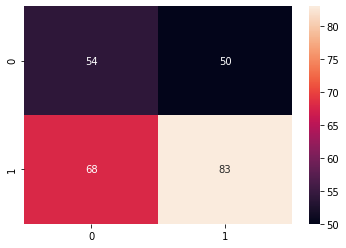

In [74]:
# visualização grafica
# classe 0 não saem da empresa 
# calsse 1 saem da empresa
sns.heatmap(cm, annot=True);

In [75]:
from sklearn.ensemble import RandomForestClassifier

In [76]:
# criação do modelo Random Forest
RFmodel = RandomForestClassifier()

In [77]:
# treinamento
RFmodel.fit(X_treino, y_treino)

RandomForestClassifier()

In [78]:
# previsão usando Random Forest
RFprev = RFmodel.predict(X_teste)

In [79]:
# accuracy do modelo
RLa = accuracy_score(y_teste, RFprev)
print(f'Accuracy de {RLa:2.2%} ')

Accuracy de 55.29% 


In [80]:
# usando bibliotecas sklearn
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report 

In [81]:
# analise usando outros indicadores
print(classification_report(y_teste, RFprev))

              precision    recall  f1-score   support

         0.0       0.46      0.59      0.52       104
         1.0       0.65      0.53      0.58       151

    accuracy                           0.55       255
   macro avg       0.56      0.56      0.55       255
weighted avg       0.57      0.55      0.56       255



In [110]:
# criação do modelo 
RN_model = tf.keras.models.Sequential()
RN_model.add(tf.keras.layers.Dense(units = 50, activation='relu', input_shape=(16,))) #relu valores menores que zero retorna zero
RN_model.add(tf.keras.layers.Dense(units = 50, activation = 'relu'))
RN_model.add(tf.keras.layers.Dense(units = 50, activation = 'relu'))
RN_model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

In [111]:
# verificação do modelo
RN_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 50)                850       
_________________________________________________________________
dense_22 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_23 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 51        
Total params: 6,001
Trainable params: 6,001
Non-trainable params: 0
_________________________________________________________________


In [112]:
RN_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [113]:
RN_model.fit(X_treino, y_treino, epochs=200)

Epoch 1/200
24/24 [==============================] - 0s 872us/step - loss: 0.6957 - accuracy: 0.5098
Epoch 2/200
24/24 [==============================] - 0s 789us/step - loss: 0.6907 - accuracy: 0.5425
Epoch 3/200
24/24 [==============================] - 0s 664us/step - loss: 0.6872 - accuracy: 0.5556
Epoch 4/200
24/24 [==============================] - 0s 706us/step - loss: 0.6881 - accuracy: 0.5451
Epoch 5/200
24/24 [==============================] - 0s 707us/step - loss: 0.6850 - accuracy: 0.5516
Epoch 6/200
24/24 [==============================] - 0s 748us/step - loss: 0.6828 - accuracy: 0.5634
Epoch 7/200
24/24 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.5791
Epoch 8/200
24/24 [==============================] - 0s 1ms/step - loss: 0.6800 - accuracy: 0.5608
Epoch 9/200
24/24 [==============================] - 0s 955us/step - loss: 0.6791 - accuracy: 0.5791
Epoch 10/200
24/24 [==============================] - 0s 1ms/step - loss: 0.6789 - accuracy: 0.

In [114]:
RNprev = RN_model.predict(X_teste)
RNprev

array([[0.17207527],
       [0.9852061 ],
       [0.6112965 ],
       [0.7394137 ],
       [0.47221786],
       [0.7223054 ],
       [0.23394585],
       [0.3483451 ],
       [0.33185047],
       [0.7151061 ],
       [0.9515135 ],
       [0.7156277 ],
       [0.7763171 ],
       [0.6313781 ],
       [0.40723422],
       [0.3252121 ],
       [0.82815504],
       [0.6720166 ],
       [0.7664912 ],
       [0.23026481],
       [0.73679763],
       [0.7025314 ],
       [0.55549604],
       [0.55242985],
       [0.87525505],
       [0.77495646],
       [0.5273424 ],
       [0.95442486],
       [0.3738711 ],
       [0.79595244],
       [0.39314783],
       [0.89087844],
       [0.64579886],
       [0.73973656],
       [0.63305664],
       [0.3223282 ],
       [0.64188325],
       [0.8154634 ],
       [0.65277356],
       [0.5889423 ],
       [0.24390775],
       [0.8825917 ],
       [0.5248153 ],
       [0.27974415],
       [0.3997512 ],
       [0.59218967],
       [0.8425249 ],
       [0.160

In [118]:
RNprev = (RNprev >= 0.50)
RNprev

array([[False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [

In [119]:
cm = confusion_matrix(y_teste, RNprev)
cm

array([[ 90,  14],
       [127,  24]], dtype=int64)

In [120]:
print(classification_report(y_teste, RNprev))

              precision    recall  f1-score   support

         0.0       0.41      0.87      0.56       104
         1.0       0.63      0.16      0.25       151

    accuracy                           0.45       255
   macro avg       0.52      0.51      0.41       255
weighted avg       0.54      0.45      0.38       255



In [ ]:
# overfiting